<a href="https://colab.research.google.com/github/AnnaBobasheva/KG-R/blob/main/Jupyter_R_notebook_querying_WeKG_dataset_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Meteorological Data Knowledge Graph - WeKG-MF 
#### maintained by the [WIMMICS team](https://team.inria.fr/wimmics/)

This notebook demonstrates how to access and query WeKG-MF RDF dataset and visualize the geographical and time series data resulting from a query. 

The WeKG-MF dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions. 

The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo. 

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf

Bevans, R. (2022, May 06). Linear Regression in R | An Easy Step-by-Step Guide. Scribbr. Retrieved November 16, 2022, from https://www.scribbr.com/statistics/linear-regression-in-r/

In [ ]:
R.Version()$version

[1] "R version 4.2.2 Patched (2022-11-10 r83330)"

## Setup


NOTE: If you are running this notebook in Google Colab it may take a long time to install some packages, for example, we've observed that installing packages `leaflet` and `treemap` takes 8 and 5 minutes respectively. At the moment we didn't find a remedy to this. Please be patient, have a cup of coffee or play [Wordle](https://www.nytimes.com/games/wordle/index.html)

### Enable querying of the Knowledge Graph  
The easiest way to access and query the dataset endpoint is to use the R package [SPARQL](https://cran.r-project.org/web/packages/SPARQL/index.html). However, it was recently removed from the CRAN repository but still can be installed from the archive. 

Alternatively, use this work: https://ourednik.info/maps/2021/12/14/execute-sparql-chunks-in-r-markdown/ .

In [ ]:
options(warn=-1) # to turn warning back on use options(warn=0)

# The package SPARQL was removed from CRAN in May, 2022. 
# To be able to use it it we need to install its prerequisites 
# and then install it from archive
if (!require(SPARQL)) {
  install.packages("XML", quiet=TRUE)
  install.packages("RCurl", quiet=TRUE)
  install.packages("https://cran.r-project.org/src/contrib/Archive/SPARQL/SPARQL_1.16.tar.gz",
                    repos=NULL, type="source",  quiet=TRUE)
}
library(SPARQL)  

### Define dataset endpoint for the SPARQL data access

NOTE: depending on the runtime environment an *https* endpoint URL may lead to an error. In this case, try to change it to *http*.

In [ ]:
endpoint <- "http://weakg.i3s.unice.fr/sparql"
options <- NULL

### Define prefixes to abbreviate namespaces

The first set of prefixes is used in the SPARQL query and the second to abbreviate the returned data.

In [ ]:
sparql_prefix <- '
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX geosparql:  <http://www.opengis.net/ont/geosparql#> 
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>

PREFIX weo: <http://ns.inria.fr/meteo/ontology/>
PREFIX wep: <http://ns.inria.fr/meteo/ontology/property/>
PREFIX wevp: <http://ns.inria.fr/meteo/vocab/weatherproperty/>
PREFIX wes-dimension: <http://ns.inria.fr/meteo/observationslice/dimension#>
PREFIX wes-measure: <http://ns.inria.fr/meteo/observationslice/measure#>
PREFIX wes-attribute: <http://ns.inria.fr/meteo/observationslice/attribute#>
'

data_prefix <- c('wekg','<http://ns.inria.fr/meteo/>', 
                 'wevp', '<http://ns.inria.fr/meteo/vocab/weatherproperty/>',
                 'wd',   '<http://www.wikidata.org/entity/>',
                 'wdt',  '<http://www.wikidata.org/prop/direct/>',
                 'qudtu', '<http://qudt.org/vocab/unit/>')

### Enable visualisation tools
The easiest way to visualize a map would be to use ```ggmap``` package. However, now it requires the use of an API key that only allows a certain number of API calls and is not suited for our purposes. The next best thing is  [Leaflet for R](https://rstudio.github.io/leaflet/) which is a wrapper over the popular Javascript library. 

NOTE: Runninig this notebook in Google Colab environment pevents rendering of the Leaflet's map widget to the output. (Find out why...) The workaround would be to save it as HTML and render in an *iframe* as described in https://stackoverflow.com/questions/67552710/how-to-display-interactive-leaflet-map-in-r-notebook-in-colab/67573334#67573334.


In [ ]:
if (!require(leaflet, quietly=TRUE)) {
  install.packages("leaflet", , Ncpus=parallel:::detectCores())
}
library(leaflet)
library(htmlwidgets)

if  (!require(IRdisplay, quietly=TRUE)) {
    install.packages("IRdisplay")
}
library(IRdisplay)

if (!require(htmltools , quietly=TRUE)){
    install.packages("htmltools")
}
library(htmltools)    


isColab <- nchar(Sys.getenv("GCE_METADATA_TIMEOUT")) > 0

# Helper functions that help rendering of the widgets  
# both natively and in the iframe
encode_widget <- function (widget) {
    widget<-gsub("%","%25",widget)
    widget<-gsub("#","%23",widget)
    widget<-gsub("\"","%22",widget)
    widget<-gsub("'" ,"%27",widget)
    widget<-gsub("\\n" ,"",widget)
    widget<-paste(widget, collapse="")
    return(widget)
}

widget2html <- function (widget, file='widget.html') {
    saveWidget(widget, file, selfcontained = TRUE)
    demo<-readLines(file)
    demo<-encode_widget(demo)

    return(demo)
}

widget2iframe <- function (widget, width="100%", height="100%")
{
    iframe.html <- '<iframe src="data:text/html;charset=UTF-8, %s" width="%s" height="%s"></iframe>'  
    iframe.html <- sprintf(iframe.html, widget2html(widget),
                            width, height)
    return(iframe.html)
}

show_widget <- function (widget ,  width="100%", height="100%")
{
  if (isColab) { 
      
    iframe.html <- widget2iframe(widget, width, height)
    display_html(iframe.html)

  } else {
    widget
  }
}

For charting of the data we will be using a popular package `gglpot2` that will allow creating graphs that represent both univariate and multivariate numerical and categorical data and `treemap` for space-filling visualization.

In [ ]:
if (!require(treemap, quietly=TRUE)) {
  install.packages("treemap", , repos="https://mirror.ibcp.fr/pub/CRAN/", quiet=TRUE)
}
library(treemap)
library(ggplot2)

if (!require("RColorBrewer")) {
  install.packages("RColorBrewer")
}
library(RColorBrewer)

To easyly manipulate timed data we use ```tsbox``` package. And for statistical method such as LASSO we use ```glmnet``` package  

In [ ]:
if (!require(tsbox, quietly=TRUE)) {
    install.packages("tsbox" , quiet = TRUE)
}
library(tsbox)

#https://www.cynkra.com/blog/2019-04-10-tsbox-01/tsbox-cheatsheet.pdf

if (!require(reshape2, quietly=TRUE)) {
    install.packages("reshape2" , quiet = TRUE)
}
library(reshape2)

if (!require(glmnet, quietly=TRUE)) {
    install.packages("glmnet" , quiet = TRUE)
}
library(glmnet)

The setup is done. 

## Visualizing meteo stations locations
The dataset has information about the location of the meteo stations. Let's query dataset for the list of French meteo stations and their georgphical coordinates and administartive beonging.

In [ ]:
query_stations <- '
# wdt:P131 = located in the administrative territorial entity
# wdt:P2585 = INSEE region code

SELECT distinct * 
WHERE {
        ?station  a weo:WeatherStation;
                  rdfs:label ?stationName;
                  geo:lat ?lat; geo:long ?long.
             
         OPTIONAL {?station dct:spatial/wdt:P131 ?region.
                   ?region rdfs:label ?regionLabel;
                           wdt:P2585 ?regionCode.}
}
ORDER BY ?regionCode ?stationName
'

query_stations <- paste(sparql_prefix, query_stations)

stations <- SPARQL(url= endpoint,
              query = query_stations,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(stations)))

[1] "Result rows: 61"


In [ ]:
options(repr.plot.width = 18)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

big.map <- leaflet(data=stations, width="52%", #height = "610px", width
                     options = leafletOptions(minZoom = 1, maxZoom= 6 )) %>% 
  addTiles() %>% 
  addControl("Meteo France Weather Stations", position = "bottomleft")  %>%
  addMarkers(~long, ~lat, popup= ~stationName)

show_widget(big.map, height = "400px")
#display_png(file="plot.png) # widget printing does not work - use this to print 
print("click on a marker to open stataion name label...")

leaflet <link href=%22data:text/css;charset=utf-8,%250A%252Eleaflet%252Dpane%252C%250A%252Eleaflet%252Dtile%252C%250A%252Eleaflet%252Dmarker%252Dicon%252C%250A%252Eleaflet%252Dmarker%252Dshadow%252C%250A%252Eleaflet%252Dtile%252Dcontainer%252C%250A%252Eleaflet%252Dpane%2520%253E%2520svg%252C%250A%252Eleaflet%252Dpane%2520%253E%2520canvas%252C%250A%252Eleaflet%252Dzoom%252Dbox%252C%250A%252Eleaflet%252Dimage%252Dlayer%252C%250A%252Eleaflet%252Dlayer%2520%257B%250Aposition%253A%2520absolute%253B%250Aleft%253A%25200%253B%250Atop%253A%25200%253B%250A%257D%250A%252Eleaflet%252Dcontainer%2520%257B%250Aoverflow%253A%2520hidden%253B%250A%257D%250A%252Eleaflet%252Dtile%252C%250A%252Eleaflet%252Dmarker%252Dicon%252C%250A%252Eleaflet%252Dmarker%252Dshadow%2520%257B%250A%252Dwebkit%252Duser%252Dselect%253A%2520none%253B%250A%252Dmoz%252Duser%252Dselect%253A%2520none%253B%250Auser%252Dselect%253A%2520none%253B%250A%252Dwebkit%252Duser%252Ddrag%253A%2520none%253B%250A%257D%250A%250A%252Eleaflet%252Dsafari%2520%252Eleaflet%252Dtile%2520%257B%250Aimage%252Drendering%253A%2520%252Dwebkit%252Doptimize%252Dcontrast%253B%250A%257D%250A%250A%252Eleaflet%252Dsafari%2520%252Eleaflet%252Dtile%252Dcontainer%2520%257B%250Awidth%253A%25201600px%253B%250Aheight%253A%25201600px%253B%250A%252Dwebkit%252Dtransform%252Dorigin%253A%25200%25200%253B%250A%257D%250A%252Eleaflet%252Dmarker%252Dicon%252C%250A%252Eleaflet%252Dmarker%252Dshadow%2520%257B%250Adisplay%253A%2520block%253B%250A%257D%250A%250A%250A%252Eleaflet%252Dcontainer%2520%252Eleaflet%252Doverlay%252Dpane%2520svg%252C%250A%252Eleaflet%252Dcontainer%2520%252Eleaflet%252Dmarker%252Dpane%2520img%252C%250A%252Eleaflet%252Dcontainer%2520%252Eleaflet%252Dshadow%252Dpane%2520img%252C%250A%252Eleaflet%252Dcontainer%2520%252Eleaflet%252Dtile%252Dpane%2520img%252C%250A%252Eleaflet%252Dcontainer%2520img%252Eleaflet%252Dimage%252Dlayer%2520%257B%250Amax%252Dwidth%253A%2520none%2520%2521important%253B%250Amax%252Dheight%253A%2520none%2520%2521important%253B%250A%257D%250A%252Eleaflet%252Dcontainer%252Eleaflet%252Dtouch%252Dzoom%2520%257B%250A%252Dms%252Dtouch%252Daction%253A%2520pan%252Dx%2520pan%252Dy%253B%250Atouch%252Daction%253A%2520pan%252Dx%2520pan%252Dy%253B%250A%257D%250A%252Eleaflet%252Dcontainer%252Eleaflet%252Dtouch%252Ddrag%2520%257B%250A%252Dms%252Dtouch%252Daction%253A%2520pinch%252Dzoom%253B%250A%250Atouch%252Daction%253A%2520none%253B%250Atouch%252Daction%253A%2520pinch%252Dzoom%253B%250A%257D%250A%252Eleaflet%252Dcontainer%252Eleaflet%252Dtouch%252Ddrag%252Eleaflet%252Dtouch%252Dzoom%2520%257B%250A%252Dms%252Dtouch%252Daction%253A%2520none%253B%250Atouch%252Daction%253A%2520none%253B%250A%257D%250A%252Eleaflet%252Dcontainer%2520%257B%250A%252Dwebkit%252Dtap%252Dhighlight%252Dcolor%253A%2520transparent%253B%250A%257D%250A%252Eleaflet%252Dcontainer%2520a%2520%257B%250A%252Dwebkit%252Dtap%252Dhighlight%252Dcolor%253A%2520rgba%252851%252C%2520181%252C%2520229%252C%25200%252E4%2529%253B%250A%257D%250A%252Eleaflet%252Dtile%2520%257B%250Afilter%253A%2520inherit%253B%250Avisibility%253A%2520hidden%253B%250A%257D%250A%252Eleaflet%252Dtile%252Dloaded%2520%257B%250Avisibility%253A%2520inherit%253B%250A%257D%250A%252Eleaflet%252Dzoom%252Dbox%2520%257B%250Awidth%253A%25200%253B%250Aheight%253A%25200%253B%250A%252Dmoz%252Dbox%252Dsizing%253A%2520border%252Dbox%253B%250Abox%252Dsizing%253A%2520border%252Dbox%253B%250Az%252Dindex%253A%2520800%253B%250A%257D%250A%250A%252Eleaflet%252Doverlay%252Dpane%2520svg%2520%257B%250A%252Dmoz%252Duser%252Dselect%253A%2520none%253B%250A%257D%250A%252Eleaflet%252Dpane%2520%257B%2520z%252Dindex%253A%2520400%253B%2520%257D%250A%252Eleaflet%252Dtile%252Dpane%2520%257B%2520z%252Dindex%253A%2520200%253B%2520%257D%250A%252Eleaflet%252Doverlay%252Dpane%2520%257B%2520z%252Dindex%253A%2520400%253B%2520%257D%250A%252Eleaflet%252Dshadow%252Dpane%2520%257B%2520z%252Dindex%253A%2520500%253B%2520%257D%250A%252Eleaflet%252Dmarker%252Dpane%2520%257B%2520z%252Dindex%253A%2520600%253B%2520%25

[1] "click on a marker to open stataion name label..."


TODO: 
- figure out how to read the name of the station from the widget

## Exploring data from a meteo station

Query the amount of available data for a station. This might be useful in deciding which weather property we can analyze. 

Copy/paste the station name from the marker label on the map above for the station you are interested in.

In [ ]:
station_name <- "NICE"

In [ ]:
query_properties <- '
SELECT ?prop  (MIN(?result) AS ?min_value)
              (MAX(?result) AS ?max_value)
              (AVG(?result) AS ?avg_value)
              (SAMPLE(?prop_unit) AS ?unit)
              (MIN(?time) AS ?min_time) 
              (MAX(?time) AS ?max_time) 
              (COUNT(DISTINCT ?obs) AS ?datapoints_count)
              (COUNT(DISTINCT ?date) AS ?days_count)
              (COUNT(DISTINCT ?year) AS ?years_count)
              (GROUP_CONCAT(DISTINCT ?interval; SEPARATOR=", ") AS ?intervals)

WHERE {
    VALUES (?stationName) {("%s")}
    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;  
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?result .

     OPTIONAL {?prop skos:prefLabel ?propLabel.}

     OPTIONAL{ ?obs sosa:phenomenonTime [ a ?interval ]. }
     OPTIONAL {?prop qudt:applicableUnit ?prop_unit. }

     BIND(xsd:date(SUBSTR(STR(?time), 1,10)) AS ?date )
     BIND(YEAR(?time) AS ?year )
}
GROUP BY ?prop 
'
query_properties <- sprintf( query_properties, station_name)
query_properties <- paste(sparql_prefix, query_properties)

weather_props <- SPARQL(url= endpoint,
              query = query_properties,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(weather_props)))

[1] "Result rows: 18"


In [ ]:
# convert date from numeric representation returned from query to R's date format
weather_props$min_time <- as.POSIXct(weather_props$min_time, origin="1970-01-01")
weather_props$max_time <- as.POSIXct(weather_props$max_time, origin="1970-01-01")

# strip prefix to shorten the text and create lables with counts
weather_props$prop_label <- paste(substring(weather_props$prop, nchar("wevp:") +1 ), "\n", 
                                    weather_props$datapoints_count, " obs", "\n", 
                                    weather_props$days_count, " days")

weather_props

prop,min_value,max_value,avg_value,unit,min_time,max_time,datapoints_count,days_count,years_count,intervals,prop_label
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dttm>,<dttm>,<int>,<int>,<int>,<chr>,<chr>
wevp:differentialPressure,-2780.00,3250.00,-8.473848e-02,qudtu:PA,2016-01-01 00:00:00,2021-12-31 21:00:00,34931,2192,6,"http://ns.inria.fr/meteo/ontology/Interval24h, http://ns.inria.fr/meteo/ontology/Interval3h",differentialPressure 34931 obs 2192 days
wevp:maxAirTemperature,275.65,308.75,2.921210e+02,qudtu:K,2016-01-01 06:00:00,2021-12-31 18:00:00,4366,2191,6,http://ns.inria.fr/meteo/ontology/Interval12h,maxAirTemperature 4366 obs 2191 days
wevp:gustSpeed,0.00,26.00,5.281218e+00,qudtu:M-PER-SEC,2016-01-01 00:00:00,2021-12-31 21:00:00,17442,2192,6,http://ns.inria.fr/meteo/ontology/Interval10m,gustSpeed 17442 obs 2192 days
wevp:cloudBaseAltitude,30.00,8400.00,1.215926e+03,qudtu:M,2016-01-01 00:00:00,2021-12-31 21:00:00,9613,2012,6,,cloudBaseAltitude 9613 obs 2012 days
wevp:totalCloudCover,0.00,101.00,4.673384e+01,qudtu:PERCENT,2016-01-01 00:00:00,2021-12-31 21:00:00,16614,2161,6,,totalCloudCover 16614 obs 2161 days
wevp:windAverageDirection,0.00,360.00,2.298274e+02,qudtu:DEG,2016-01-01 00:00:00,2021-12-31 21:00:00,17502,2192,6,http://ns.inria.fr/meteo/ontology/Interval10m,windAverageDirection 17502 obs 2192 days
wevp:horizontalVisibility,60.00,60000.00,3.316810e+04,qudtu:M,2016-01-01 00:00:00,2021-12-31 21:00:00,17502,2192,6,,horizontalVisibility 17502 obs 2192 days
wevp:minAirTemperature,271.35,301.95,2.872667e+02,qudtu:K,2016-01-01 06:00:00,2021-12-31 18:00:00,4366,2191,6,http://ns.inria.fr/meteo/ontology/Interval12h,minAirTemperature 4366 obs 2191 days
wevp:lowCloudCover,0.00,9.00,2.255002e+00,wekg:vocab/unit/okta,2016-01-01 00:00:00,2021-12-31 21:00:00,17494,2192,6,,lowCloudCover 17494 obs 2192 days


### Visualize the number of observations per weather property

In [ ]:
options(repr.plot.width = 18)
options(repr.plot.height = 7)
options(repr.plot.align = 'left')

tm <-treemap(weather_props,
            index="prop_label",
            vSize="datapoints_count",
            type="index",
            palette="Pastel2",
            fontsize.labels=20,
            inflate.labels = FALSE,
            title="Treemap of number of observations per weather property",
            fontsize.title=c(20),
            #aspRatio=3/2,
            vp=grid::viewport(width=grid::unit(18, 'inch'), height=grid::unit(7, 'inch')) 
            )

ERROR: ignored

From looking at this treemap we can work out that: 
- majority of the observations are taken 8 times a day (every 3 hours) during 2189 days (6 years)
- 2 properties `minAirTemperature` and `minAirTemperature` are the aggregates of temperature for a day taken 2 times a day
- 2 properties `cloudBaseAltitude`, `totalCLoudCover` are missing  more than 10 days of observations
- 2 properies `percipitationAmount` and `diffrentialPressure` observations are recorded twice at the same time and represent cumulative values or difference respectivly for 3 hours and for 12 hours.


### Visualize the range of values  for each weather property

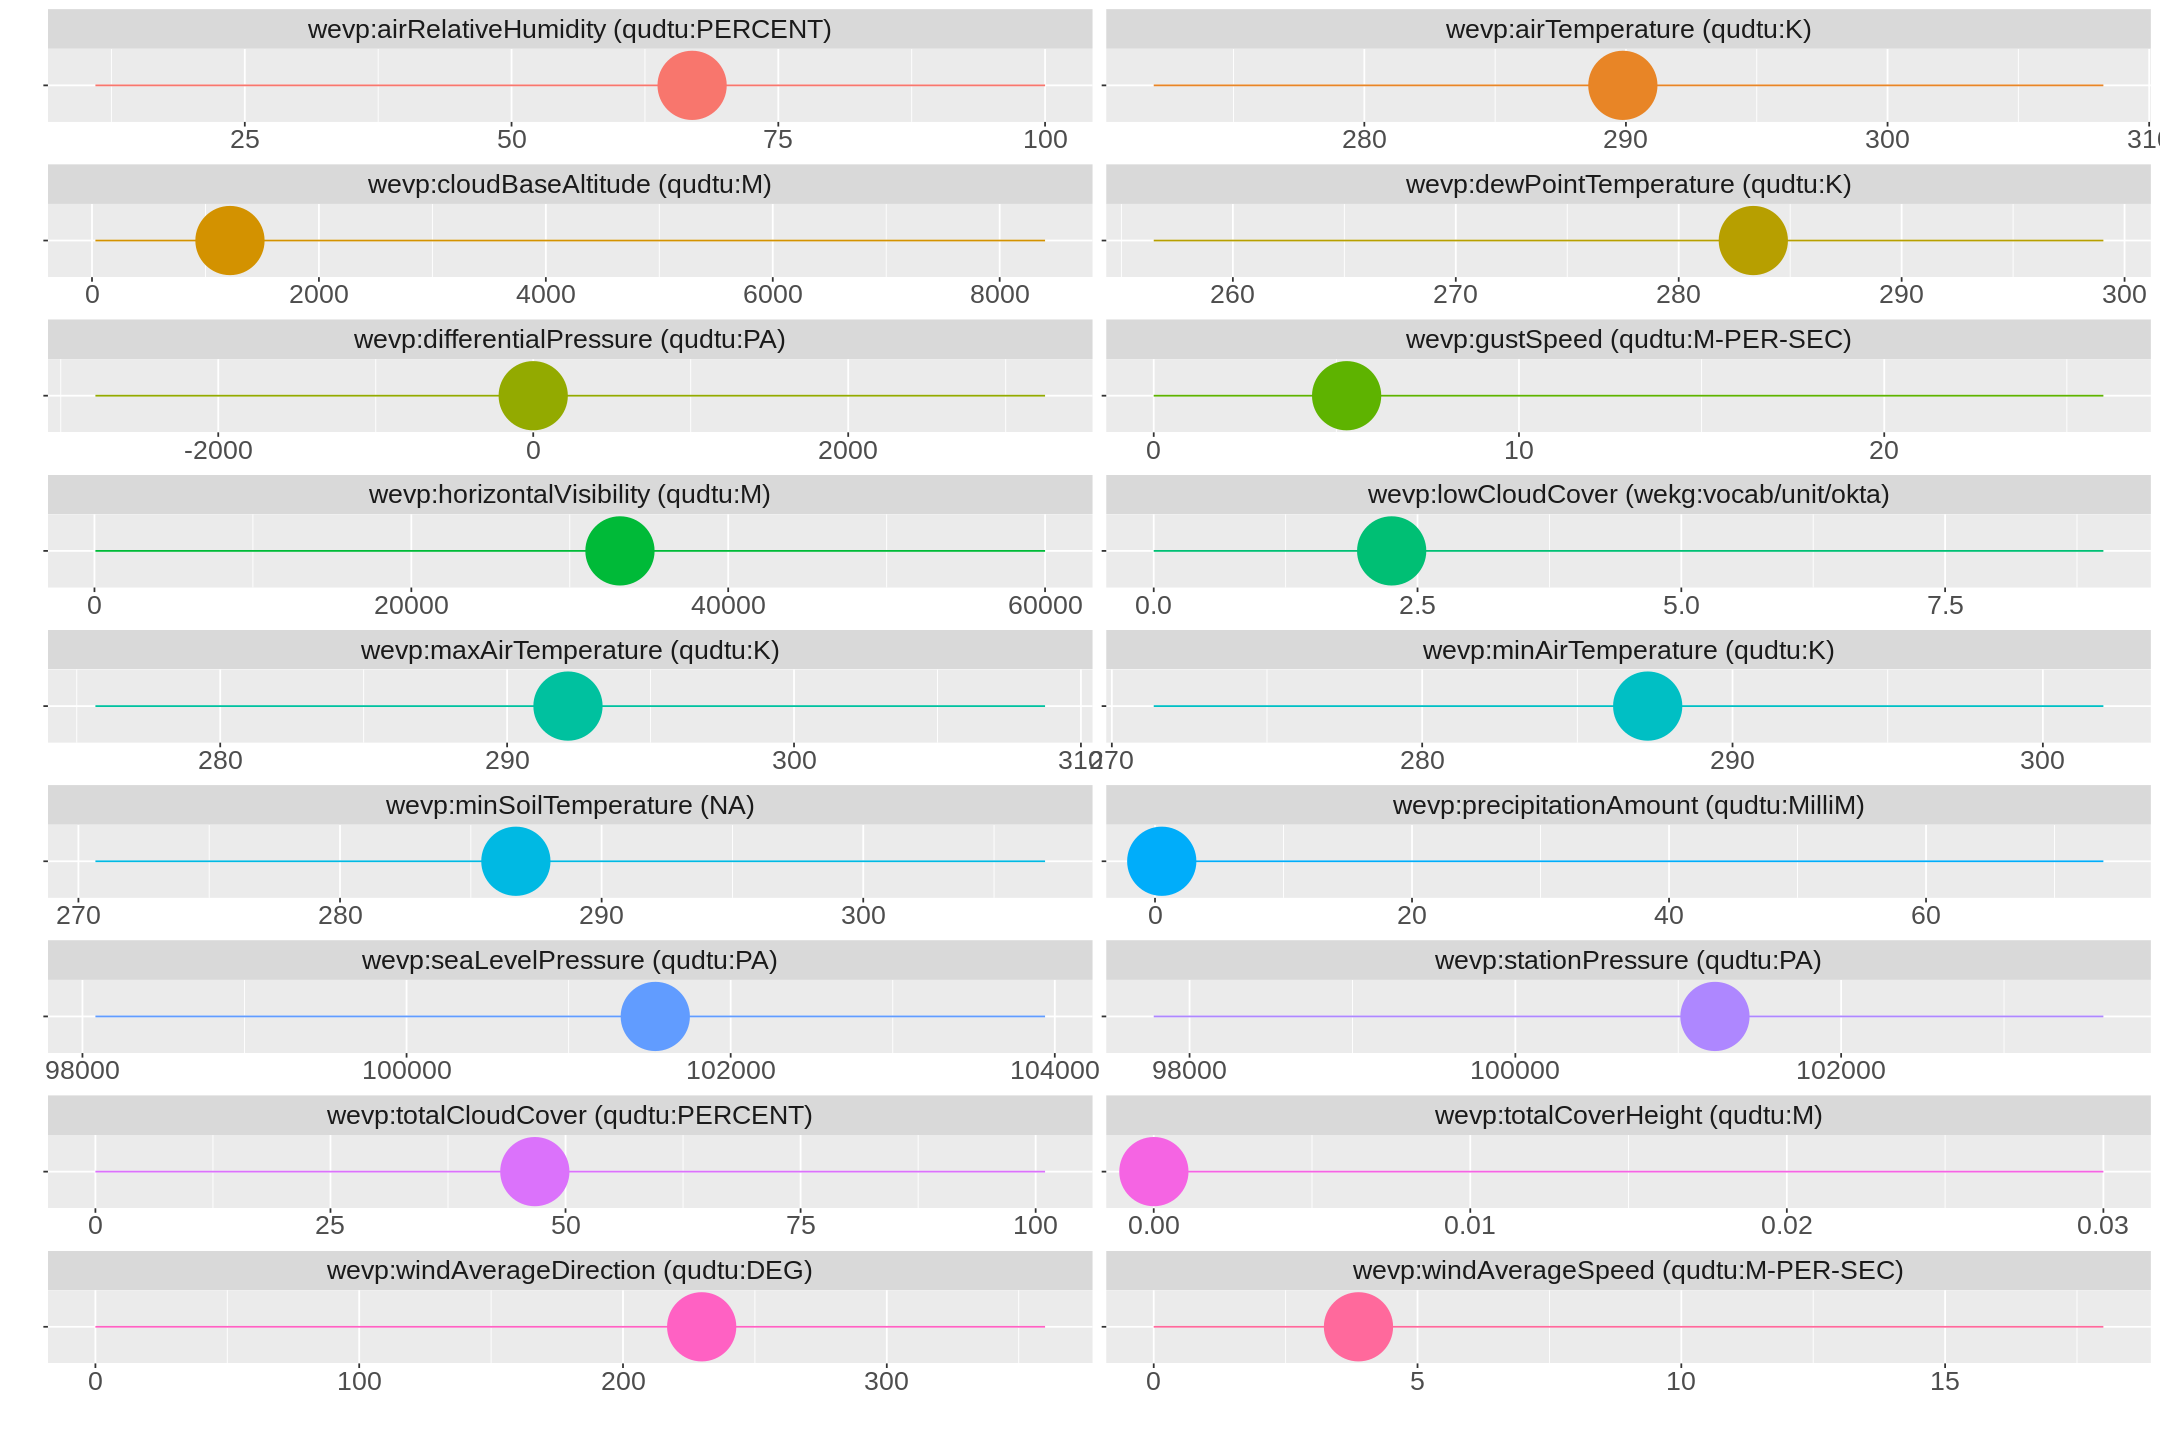

In [ ]:
options(repr.plot.width = 18)
options(repr.plot.height = 12)
options(repr.plot.align = 'left')

prop.labels <- sprintf("%s (%s)" , weather_props$prop, weather_props$unit ) 
names(prop.labels) <- weather_props$prop

ggplot(data = weather_props, mapping = aes(x = prop, y = avg_value , col=prop) )  +
    geom_pointrange(aes(ymin = min_value, ymax = max_value, size=0.1)) + 
    xlab("") +
    ylab("") +
    theme(text = element_text(size=20), 
          legend.position="none", 
          axis.text.y= element_blank()) + 
    facet_wrap(~prop, nrow= ceiling(nrow(weather_props) / 2), ncol=2, 
               strip.position = "top",
               scale="free",
                labeller = as_labeller(prop.labels) ) +
    coord_flip()

## Hypothesis Testing with Linear Regression

Intuitively we assume that air temperature might be dependent on other weather factors like relative humidity or/and wind speed. We can test this hypothesis (or rather the null hypothesis that there is no significant relationship) by trying to detect a linear relationship between `airTemperature` and `airRelativeHumidity` and/or `windAverageSpeed`.  

### Query values for selected weather properties

The data server returns the maximum of 50,000 rows of data so we cannot request all the data at once. We can either 
- use a loop with LIMIT and OFFSET clauses (not discussed here) or 
- take one year of measurements using FROM to restrict queriable graphs (current query) or
- or we can get as much data as we can from the beginning of the observation time (comment FROM clauses)

In [ ]:
query_properties_data <- '
SELECT ?prop  ?time ?value

FROM <http://ns.inria.fr/meteo/observation/2016>
FROM <http://ns.inria.fr/meteo/weatherstation>

WHERE {
    VALUES (?stationName) {("%s")}
    VALUES (?prop) { ( wevp:airTemperature ) 
                     #( wevp:airRelativeHumidity )
                     ( wevp:windAverageSpeed ) }
    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;  
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?value.

     BIND(xsd:date(SUBSTR(STR(?time), 1,10)) AS ?date )
     BIND(YEAR(?time) AS ?year )
}
ORDER BY ?time
'

query_properties_data <- sprintf( query_properties_data, station_name)
query_properties_data <- paste(sparql_prefix, query_properties_data)

weather_data <- SPARQL(url= endpoint,
              query = query_properties_data,
              ns=data_prefix,
              extra=NULL)$results

# convert date from numeric representation returned from query to R's date format
weather_data$time <- as.POSIXct(weather_data$time, origin="1970-01-01")

# remove prefix from the property names to make life easier 
# when property names will become column names
weather_data$prop <- sapply(weather_data$prop, FUN=function(x) gsub("^.*?:", "", x) )

print(paste('Result rows:', nrow(weather_data)))

[1] "Result rows: 5839"


We want to have the datapoints for each weather property aligned on the time scale. We can take advantage of "wide" time series format, where each row represents a time point with all the weather properties values. As oppose to the "long" format where each value has a row like a result of the query. 

It's convinient to go from one format to another as different functions work better with different representations.

In [ ]:
options(width=80)

weather_data.wide <- ts_wide(weather_data)

summary(weather_data.wide)

      time                        airTemperature  windAverageSpeed
 Min.   :2016-01-01 00:00:00.00   Min.   :276.2   Min.   : 0.00   
 1st Qu.:2016-04-01 06:45:00.00   1st Qu.:284.9   1st Qu.: 2.50   
 Median :2016-07-02 04:30:00.00   Median :289.4   Median : 3.60   
 Mean   :2016-07-01 22:43:29.45   Mean   :289.8   Mean   : 4.04   
 3rd Qu.:2016-10-01 11:15:00.00   3rd Qu.:295.1   3rd Qu.: 5.00   
 Max.   :2016-12-31 21:00:00.00   Max.   :305.9   Max.   :17.20   
                                  NA's   :5                       

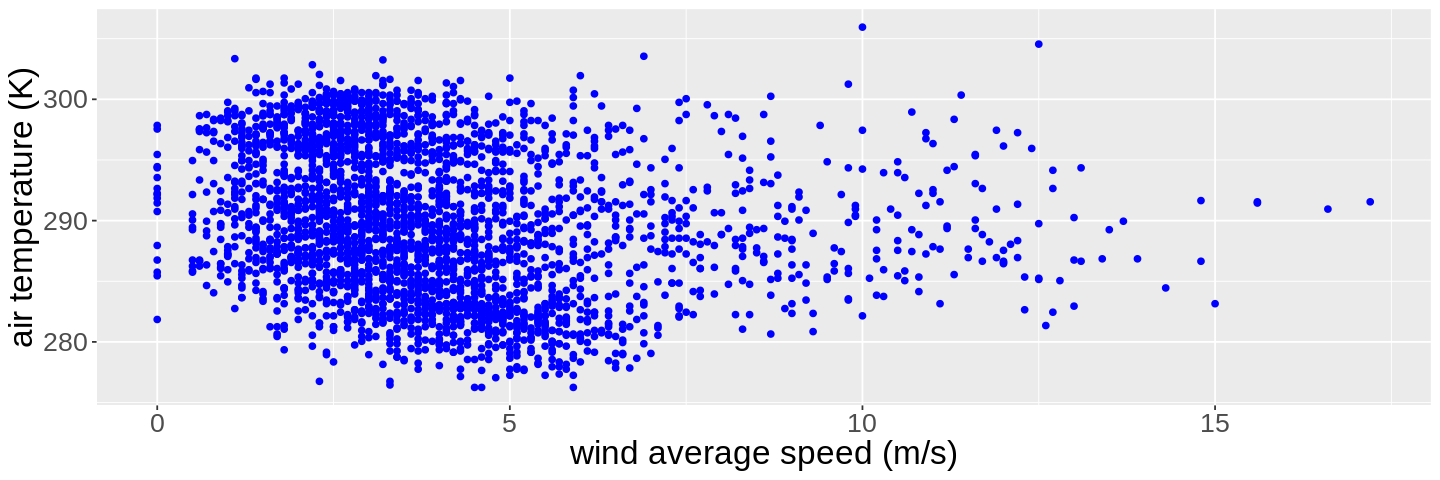

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 4)
options(repr.plot.align = 'left')

# refactor
column.labels = c("airTemperature" = "Temperature (K)",
                  "airRelativeHumidity"="Relative Humidity (%)",
                  "windAverageSpeed" = "Average Wind Speed (m/sec)") 

library(scales)
column.colors = hue_pal()(length(column.labels))
names(column.colors) <- sort(names(column.labels))


ggplot(weather_data.wide, aes(x=windAverageSpeed, y=airTemperature )) +
       geom_point(color="blue" ) +
       theme(text = element_text(size=20) ) + 
       xlab("wind average speed (m/s)")  + 
       ylab("air temperature (K)")

### Handle missing values
Perhaps not all of the time points have all the weather property values. We can identify them and if there are only a few we can drop them.

In [ ]:
print("MISSING VALUES")

weather_data.wide [rowSums(is.na(weather_data.wide)) > 0, ]

# drop missing values
weather_data.wide <- na.omit(weather_data.wide)

[1] "MISSING VALUES"


,time,airTemperature,windAverageSpeed
,<dttm>,<dbl>,<dbl>
393,2016-02-19 00:00:00,NA,4.0
445,2016-02-25 12:00:00,NA,2.4
446,2016-02-25 15:00:00,NA,5.0
2614,2016-11-23 09:00:00,NA,12.7
2615,2016-11-23 12:00:00,NA,14.2


In [ ]:
# reshape to a "long" format
weather_data.long <- ts_long(weather_data.wide )
      
print(paste('Wide format rows:', nrow(weather_data.wide)))
print(paste('Long format rows:', nrow(weather_data.long)))

[1] "Wide format rows: 2917"
[1] "Long format rows: 5834"


### Handle outliers

Outliers increase the variability in the data, which decreases statistical power. Some outliers represent natural variations in the measurements, and they should be left in the dataset. These are called true outliers. Other outliers can represent measurement errors, data entry or processing errors, or poor sampling and should be removed from the dataset. 

For example, intuitively we know that a strong wind is a rear event in many parts of France and is not representative of normal weather. 

For simplicity reasons, we can remove all of the outliers using the interquartile range method provided by ```boxplot``` functionality.

TODD:
- possibly do outliers analysis

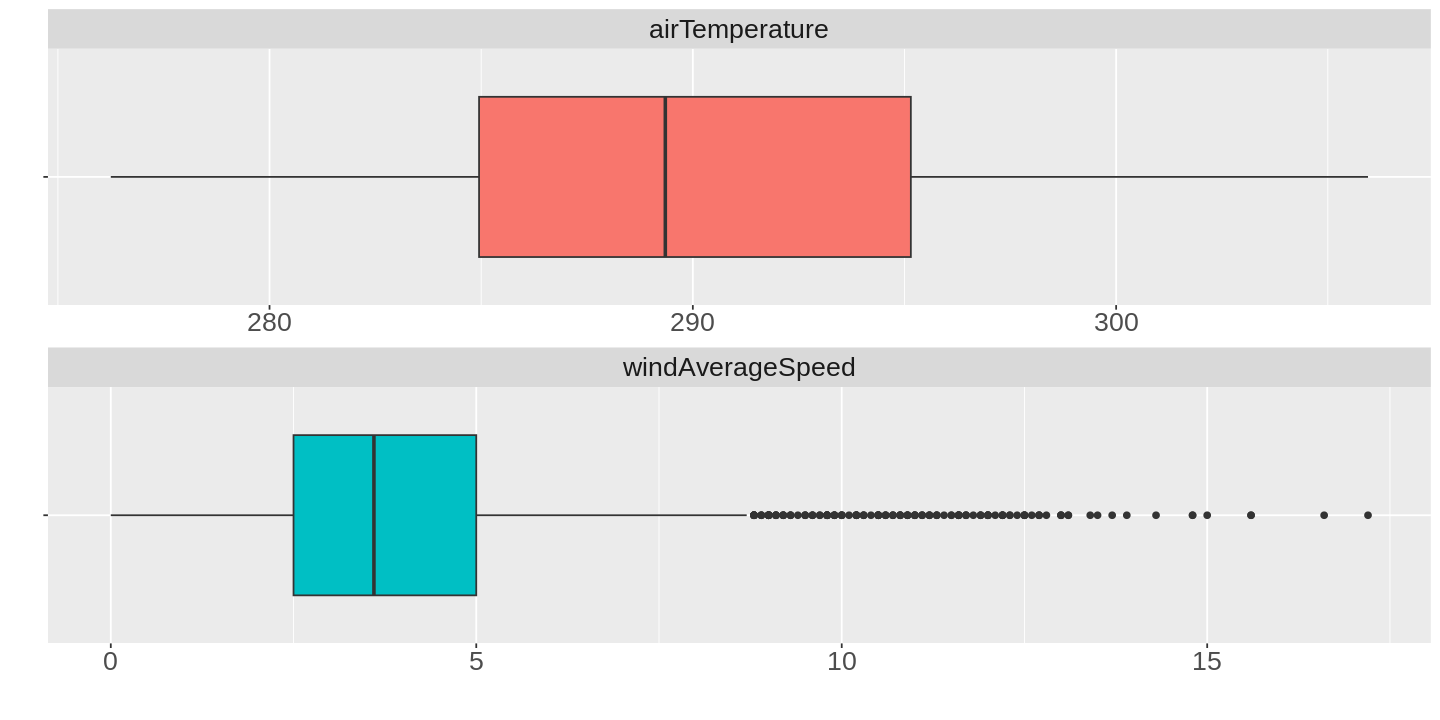

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 6)
options(repr.plot.align = 'left')

ggplot(weather_data.long) +
    geom_boxplot( aes(x=value, y=id, fill=id), notch=FALSE, coef=1.5 ) +
    theme(text = element_text(size=20), 
          axis.text.y=element_blank()  , 
          legend.position="none" ) +
    #geom_jitter(color="black", size=0.4, alpha=0.9) +
    ylab("") +
    xlab("") +
    facet_wrap(~id, nrow = 2, #length(column.labels) , 
               scales = "free",
               shrink=FALSE,
               strip.position = "top") 
               #labeller = as_labeller(column.labels) ) 


We can see that temperature data does not have any outliers but the wind speed data contains quite a few.

In [ ]:
drop.outliers <- TRUE

prop.names <- unique(weather_data.long$id)


if (drop.outliers) {
    outliers <- boxplot(weather_data.wide$windAverageSpeed, plot=FALSE)$out
    outliers_rows <- which(weather_data.wide$windAverageSpeed %in% outliers)
        
    print(sprintf ("Removing %d outliers",  length(outliers_rows)) )
    weather_data.wide <- weather_data.wide[-outliers_rows ,]

    # reshape to a "long" format
    weather_data.long <- ts_long(weather_data.wide )

    print("After dropping outliers")
    print(paste('Wide format rows:', nrow(weather_data.wide)))
    print(paste('Long format rows:', nrow(weather_data.long)))
}

[1] "Removing 151 outliers"
[1] "After dropping outliers"
[1] "Wide format rows: 2766"
[1] "Long format rows: 5532"


### Simple linear regression

Let's build a linear regression model to check out our intuition that there is a relationsip between `airTemperature` and `windAverageSpeed`. 

In [ ]:
temp.wind.lm <- lm(airTemperature ~ windAverageSpeed, data = weather_data.wide)

summary(temp.wind.lm)


Call:
lm(formula = airTemperature ~ windAverageSpeed, data = weather_data.wide)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.3846  -4.9810  -0.3776   5.0146  17.0314 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      293.44255    0.26685 1099.64   <2e-16 ***
windAverageSpeed  -1.00347    0.06628  -15.14   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.88 on 2764 degrees of freedom
Multiple R-squared:  0.07658,	Adjusted R-squared:  0.07624 
F-statistic: 229.2 on 1 and 2764 DF,  p-value: < 2.2e-16


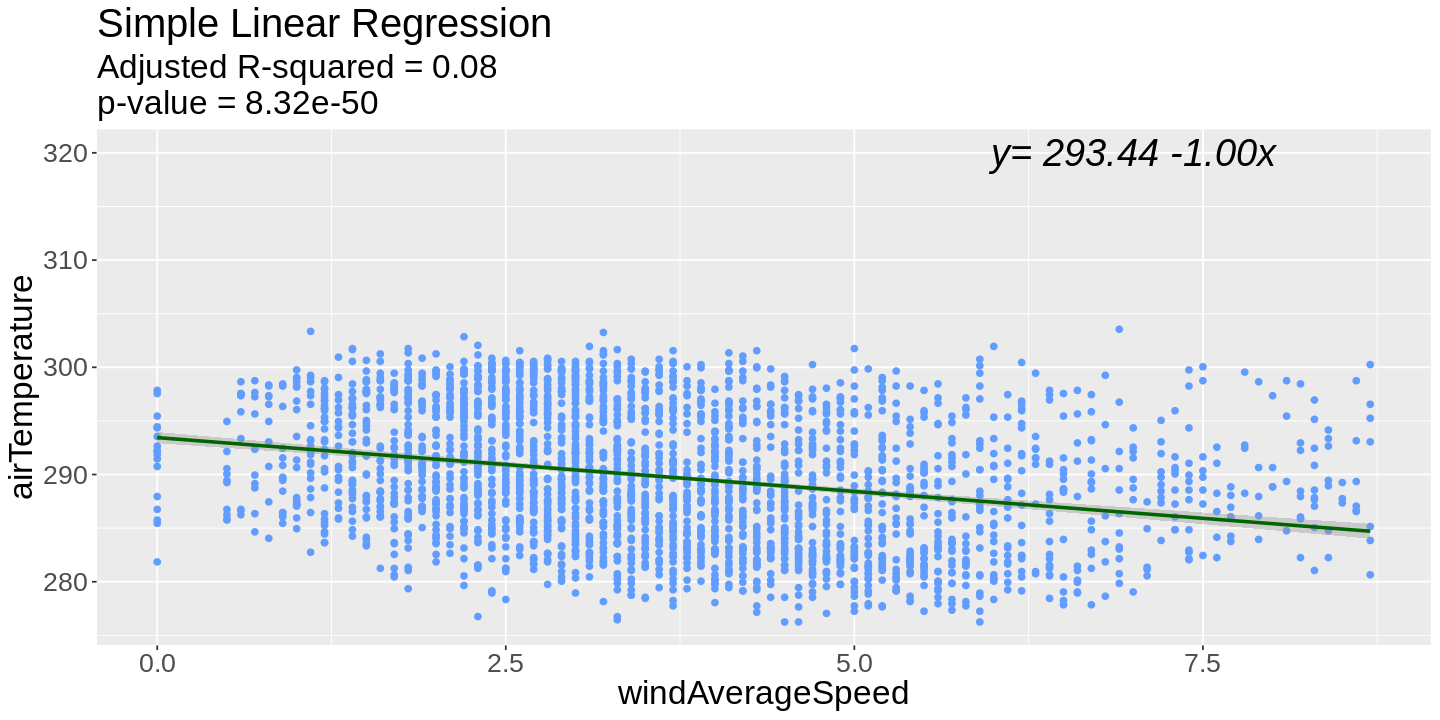

In [ ]:
lm.quality <- sprintf("Adjusted R-squared = %.2f\np-value = %.2e", summary(temp.wind.lm)$adj.r.squared, 
                                                                  summary(temp.wind.lm)$coef[2,4] )

lm.formula <- sprintf("y= %.2f %.2fx", temp.wind.lm$coef[[1]], temp.wind.lm$coef[[2]])


ggplot(temp.wind.lm$model , aes(x=windAverageSpeed, y=airTemperature )) + 
       geom_point(color=column.colors[["windAverageSpeed"]]) +
       stat_smooth(method = "lm", color="darkgreen", formula=y ~ x) +
       annotate("text", x=7, y=320, label= lm.formula , size = 8, fontface = "italic") +
       theme(text = element_text(size=20)) +
       ggtitle(label= "Simple Linear Regression", subtitle=lm.quality) 

CONCLUSION: 

We built a Linear Regression with and without removing outliers. We found a significant relationship between `airTemperature` and `windAverageSpeed` in both cases with p-value << 0.001. However, removing outliers shows a stronger effect of the wind speed  on the temperature. 

- with outliers: ~ 0.5 degree decrease in air temperature for every 1 m/sec increase of wind speed 
- without outliers: ~ 1.0 degree decrease in air temperature for every 1 m/sec increase of wind speed
- the coefficient of determination (R2) is a low 0.08 which means that wind speed can explain only 8% of the variance in the air temperature values. 

This corresponds to our common sense knowledge that the weather is a complex system and the temperature depends on many more weather factors.

Let's see if this linear model works well to describe the relationship between `windAverageSpeed` and `airTemperature` and meets the assumptions of a linear regression.

For univariate LR the data should meet the following assumptions:

1. Linearity of the data 
2. Normality of residuals 
3. Homogeneity of residuals variance (homoscedasticity) 
    
It is very easy to do in R by just plotting the diagnostics plots of LR.

| Assumption          | Plot              | What should we see |
| :----               | :----             | :---       |
| __Linearity__       |Residual vs. Fitted| There should be a straight red line close to 0.|
| __Normality__       |Normal Q-Q         | The normal probability plot of residuals should approximately follow a straight line.|
| __Homoscedasticity__|Scale-Location     | The residuals should be equally spread along a horizontal red line.  |


The fourth _Residuals vs Leverage_ plot can help to detect the outliers. Look for the points that are above and below 3 standard deviations on this plot.  

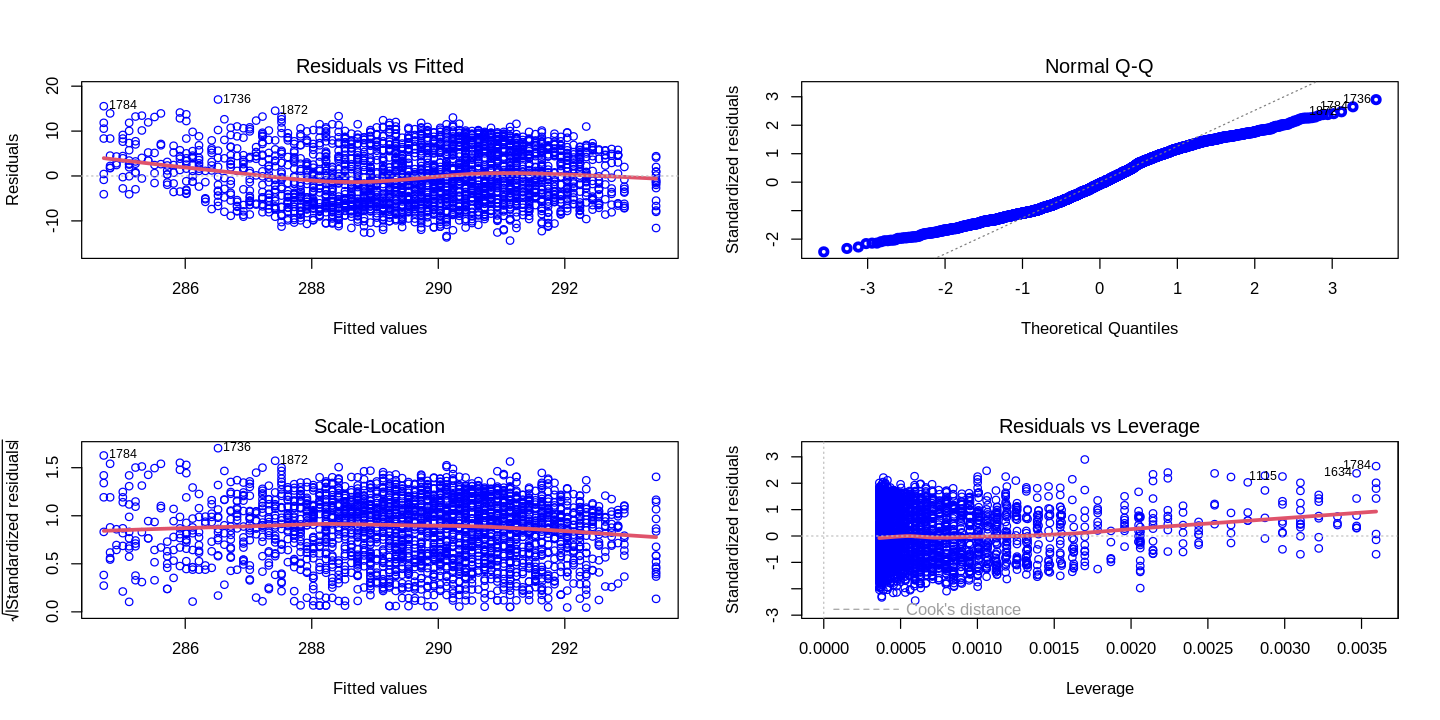

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 6)

par(mfrow=c(2,2))
plot(temp.wind.lm, col = "blue" , lwd=3)
par(mfrow=c(1,1))

CONCLUSION: 


By looking at the diagnostics plot, we can see that our regression model meets the linear regression assumptions. 

- __[x] Linearity of the data__
- __[x] Normality of residuals__
- __[x] Homoscedasticity__

## Variable selection and multivariate regression

As we can see, one weather factor cannot explain the temperature variation. The WeKG contains many weather properties collected over the years. We can try discovering what other weather factors may influence the air temperature.

The idea of variable selection is to find the "best" set of weather properties that can be used to estimate the air temperature.  

### Query data for all weather properties for one year

First, we query the wether properties values for 2016
- excluding aggregated properties `minAirTemperature` and `maxAirTemperature` 
- excluding `cloudBaseAltidude`and `wevp:totalCloudCover` that do not have enough observations
- excluding measurements cumulative/differential observations over 12 hours in the cases of `percipitationAmount` and `differentialPressure`. 

We use FROM clause to select data only from 2016
We use FILTER clause of the SPARQL query to exclude properties

In [ ]:
query_all_properties_data <- '
SELECT ?prop  ?time ?value 
       #?interval

FROM <http://ns.inria.fr/meteo/observation/2016>
FROM <http://ns.inria.fr/meteo/weatherstation>

WHERE {
    VALUES (?stationName) {("%s")}

    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;  
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?value.

     OPTIONAL { ?obs sosa:phenomenonTime [ a ?interval ]. }

     FILTER (?prop NOT IN (wevp:minAirTemperature, wevp:maxAirTemperature, 
                           wevp:cloudBaseAltitude, wevp:totalCloudCover) )

     FILTER (?interval != weo:Interval24h || !BOUND(?interval) )

}
ORDER BY ?time ?prop ?value
'

query_all_properties_data <- sprintf( query_all_properties_data, station_name)
query_all_properties_data <- paste(sparql_prefix, query_all_properties_data)

weather_data_all <- SPARQL(url= endpoint,
                          query = query_all_properties_data,
                          ns=data_prefix,
                          extra=NULL)$results

# convert date from numeric representation returned from query to R's date format
weather_data_all$time <- as.POSIXct(weather_data_all$time, origin="1970-01-01")

# remove prefix from the property names to make life easier 
# when property names will become column names
weather_data_all$prop <- sapply(weather_data_all$prop, FUN=function(x) gsub("^.*?:", "", x) )

print(paste('Result rows:', nrow(weather_data_all)))

[1] "Result rows: 40731"


### Data wrangling

We can perform some basic data manipulations like excluding duplicates, outliers and missing values. 

In [ ]:
options(width=80)

# Turn on deduplication if ts_wide function complains about the duplicates 
deduplicate <- FALSE

if (deduplicate) {
    weather_data_all.dedup <-  weather_data_all[ !duplicated(weather_data_all[, c("time", "prop")]), ]
    
    print(paste('Deduplicated rows:', nrow(weather_data_all.dedup)))
}

weather_data_all.wide <- ts_wide(weather_data_all)
print(paste('Wide format rows :', nrow(weather_data_all.wide)))

# We can instruct the analysis functions simply not to use the missing values
# To explicitly remove the missing values turn on 
drop.missing <-TRUE

if (drop.missing) {
   weather_data_all.wide <- na.omit(weather_data_all.wide)

   print("After removing missing values")
   print(paste('Wide format rows :', nrow(weather_data_all.wide)))
}

# We can try to select features with or vthout removing the outliers
# here will concider the outliers the values that are beyond 3 standard deviations 
# for a property ditribution
drop.outliers <- TRUE

if (drop.outliers) {
    prop.names <- unique(weather_data_all$prop)
    outliers_rows <- c()
    for (p in  prop.names) {
       bp <- boxplot(weather_data_all.wide[, p], plot=FALSE)
       outliers <- bp$out
                
       if (bp$stats[2] < bp$stats[4]) {
          print(sprintf ("Removing %d %s outliers",  length(outliers), p) )
          outliers_rows <- c(outliers_rows ,  which(weather_data_all.wide[ ,p] %in% outliers))
       }
    }

    if (length(outliers_rows) > 0) {
          weather_data_all.wide <- weather_data_all.wide[-outliers_rows ,]
    }
   print("After removing outliers")
   print(paste('Wide format rows :', nrow(weather_data_all.wide)))
}

summary(weather_data_all.wide)

[1] "Wide format rows : 2922"
[1] "After removing missing values"
[1] "Wide format rows : 2826"
[1] "Removing 35 airRelativeHumidity outliers"
[1] "Removing 0 airTemperature outliers"
[1] "Removing 9 dewPointTemperature outliers"
[1] "Removing 77 differentialPressure outliers"
[1] "Removing 164 gustSpeed outliers"
[1] "Removing 0 horizontalVisibility outliers"
[1] "Removing 140 lowCloudCover outliers"
[1] "Removing 0 minSoilTemperature outliers"
[1] "Removing 150 seaLevelPressure outliers"
[1] "Removing 149 stationPressure outliers"
[1] "Removing 0 windAverageDirection outliers"
[1] "Removing 148 windAverageSpeed outliers"
[1] "After removing outliers"
[1] "Wide format rows : 2362"


      time                        airRelativeHumidity airTemperature 
 Min.   :2016-01-01 12:00:00.00   Min.   :29.00       Min.   :276.2  
 1st Qu.:2016-04-14 12:45:00.00   1st Qu.:57.00       1st Qu.:285.4  
 Median :2016-07-13 18:00:00.00   Median :68.00       Median :289.9  
 Mean   :2016-07-08 14:21:17.22   Mean   :66.21       Mean   :290.2  
 3rd Qu.:2016-09-30 23:15:00.00   3rd Qu.:76.00       3rd Qu.:295.6  
 Max.   :2016-12-31 21:00:00.00   Max.   :93.00       Max.   :303.6  
 dewPointTemperature differentialPressure   gustSpeed      horizontalVisibility
 Min.   :262.9       Min.   :-240.000     Min.   : 0.000   Min.   : 1820       
 1st Qu.:278.6       1st Qu.: -60.000     1st Qu.: 3.200   1st Qu.:25000       
 Median :284.1       Median :   0.000     Median : 4.500   Median :30000       
 Mean   :283.6       Mean   :   2.815     Mean   : 4.804   Mean   :33854       
 3rd Qu.:288.6       3rd Qu.:  60.000     3rd Qu.: 6.100   3rd Qu.:40000       
 Max.   :295.9       Max.   : 

### Correlation analysis
Let's perform a correlation analysis of the weather properties to discover their pair-wise relationship and how strong this relationship may be. 

We calculate the Pearson correlation coefficient (r), which measures a linear dependence between two variables. The rule of thumb for interpreting the strength of the relationship between two variables based on the value of r:

| Absolute value of r | Strength of relationship |
| :----:              | :----                    |
|        r < 0.25     | No relationship          |
| 0.25 < r < 0.5      | Weak relationship        |
| 0.5  < r < 0.75     | Moderate relationship    |
| 0.75 < r            | Strong relationship      |

- TODO: plot with corrplot https://statsandr.com/blog/correlation-coefficient-and-correlation-test-in-r/#correlation-matrix-correlations-for-all-variables

In [ ]:
# drop non-numeric time column
weather_data_all.wide.cor <- subset(weather_data_all.wide, select = -c( time ) )

# missing values are removed by use = "complete.obs"
r <- cor(weather_data_all.wide.cor, method = "pearson", use = "complete.obs")

#round(r, 2)

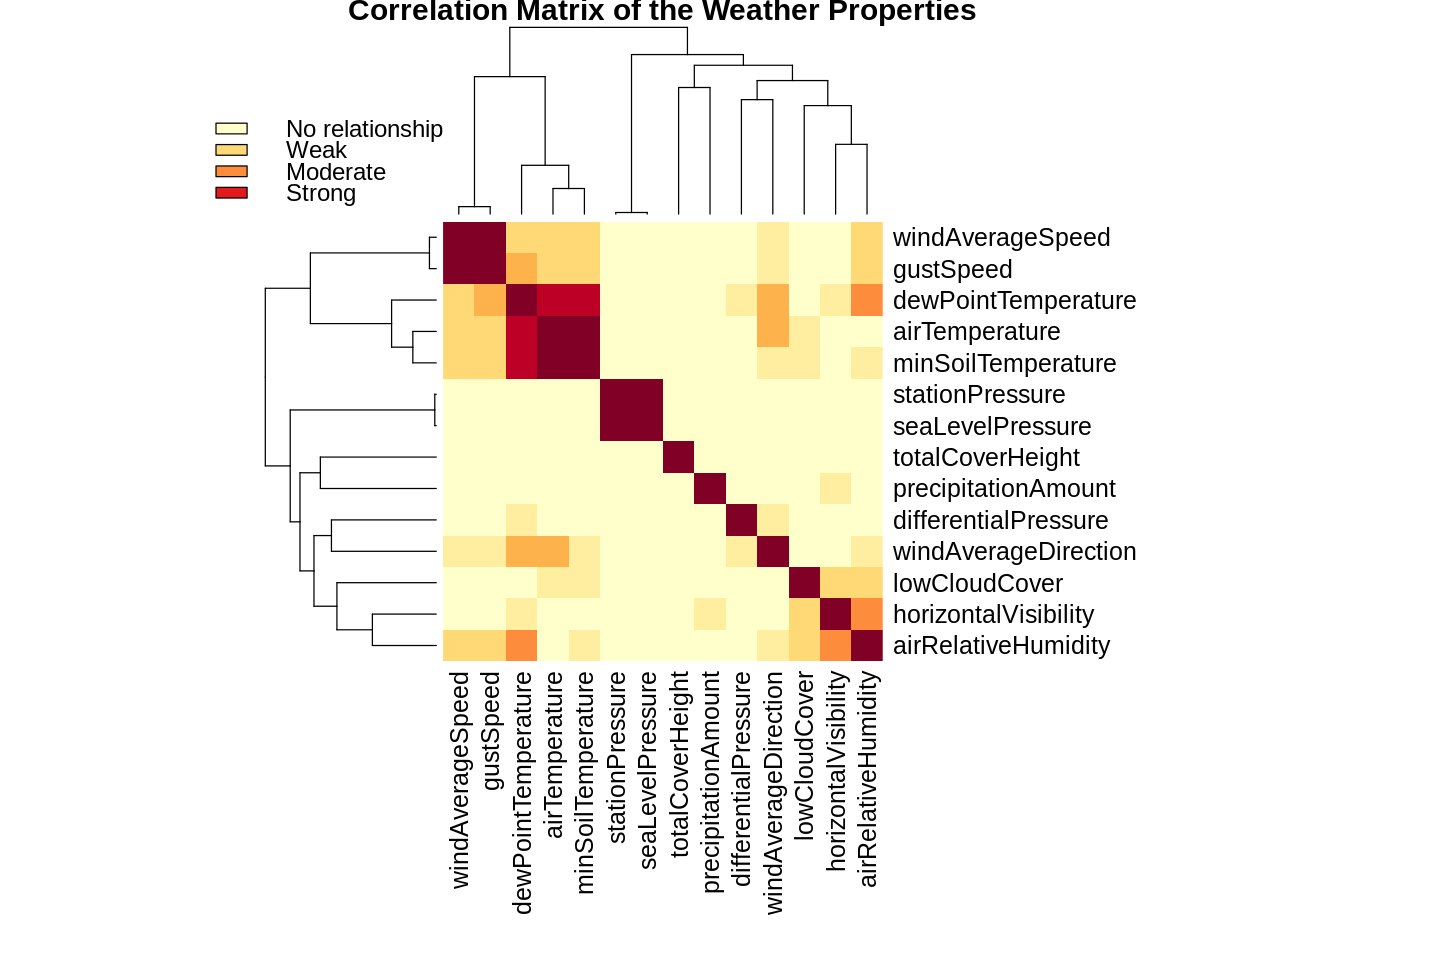

In [ ]:
# more visualization tools here http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software

options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

col <- brewer.pal(9, "YlOrRd")

par(mfrow=c(2,1))

# replace NA with 0 because for a straight line cor function sets te corelation to NA
# it seems that the heatmap's na.rm does not work
r[is.na(r)] <- 0

heatmap(x = abs(r),  symm = TRUE,
        margins = c(15,15), 
        main="Correlation Matrix of the Weather Properties",
        cexCol=1.5,
        cexRow = 1.5,
        col=col,
        na.rm=TRUE)

par(mfrow=c(1,1))      

leg.col <- col[c(1, 3,5,7)]
legend(0,1.3, #x="bottomleft", 
       legend=c("No relationship", "Weak", "Moderate", "Strong"),
       fill=leg.col,
       bty="n",
       cex=1.2,
       )


#r.melted <- melt(round(r, 2))
#ggplot(data = r.melted, aes(x=Var1, y=Var2, fill=value)) + 
#  geom_tile()


CONCLUSION:

From the heatmap of the correlation matrix we can tell that ```airTemperature``` has 
- strong relationships with `minSoilTemperature` and `dewPointTemperature`
- weak relationships with `windAverageDirection`, `gustSpeed`, and `windAverageSpeed` 
- we also see the "obvious" strong correlation between the wind speeds `windAverageSpeed` and `gustSpeed` however it is surprising to see a weak relations between `airRealtiveHumidity` and wind speed
- we see realtions between the visibility and cloud cover  
- we see the realtions between the pressure properties

This shows us that in this set of properties if we want to do a linear regression to model one property dependency on another and if we choose to use all of the properties we will violate the fourth assumption of linear regression _independence_. 

To build a good multivariate regression we need to select the independent variables (predictors).

### Feature selection with LASSO


The LASSO (Least Absolute Shrinkage and Selection Operator) model is used for the selection and reduction of parameters for regression. It can determine a minimal number of variables that gives the largest predictive power. This method helps to deal with _multicolinearity_.

We can use the 10 fold cross validation method of the ```glmnet``` package to dtermine the best hyperparameter λ and fit the LASSO regression.

In [ ]:
# split the data on dependent and independent variables 
# and scale the data
weather_data_all.wide.lasso.x <- scale(subset(weather_data_all.wide, select = -c( time, airTemperature  ) ))
weather_data_all.wide.lasso.y <- scale(weather_data_all.wide$airTemperature)

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 6)
options(repr.plot.align = 'left')

# finding the best hyperparameter with 10 fold cross-validattion
set.seed(42)
temp.all.lasso.cv <- cv.glmnet(weather_data_all.wide.lasso.x,
                         weather_data_all.wide.lasso.y, 
                         alpha=1, # LASSO
                         family = "gaussian",
                         nfold=10)

#plot(temp.all.lasso.cv)

temp.all.lasso.cv

coef(temp.all.lasso.cv, s=c(temp.all.lasso.cv$lambda.min ,temp.all.lasso.cv$lambda.1se ))


Call:  cv.glmnet(x = weather_data_all.wide.lasso.x, y = weather_data_all.wide.lasso.y,      nfolds = 10, alpha = 1, family = "gaussian") 

Measure: Mean-Squared Error 

      Lambda Index  Measure       SE Nonzero
min 0.001937    67 0.008569 0.001571      10
1se 0.015000    45 0.010119 0.001662       5

14 x 2 sparse Matrix of class "dgCMatrix"
                                s1            s2
(Intercept)          -6.674961e-15 -6.522859e-15
airRelativeHumidity  -5.342501e-01 -4.948855e-01
dewPointTemperature   1.039335e+00  9.895046e-01
differentialPressure -1.590232e-03  .           
gustSpeed             3.324155e-03  .           
horizontalVisibility -8.943869e-03  .           
lowCloudCover         3.026886e-03  .           
minSoilTemperature    6.494191e-02  9.102114e-02
precipitationAmount   1.114653e-02  .           
seaLevelPressure     -1.104800e-02 -7.692677e-04
stationPressure       .             .           
totalCoverHeight      .             .           
windAverageDirection -1.144666e-02 -1.177613e-02
windAverageSpeed      .             .           

We have two models selected for us:

- the model that produced a minimum MSE at `λ=0.002` with 10 non-zero variables 
- the model that produced MSE within 1 standard deviation at `λ=0.015` with 5 non-zero variables

We'll take the lesser number of variables and build a linear regression to see how adding multiple variables improved air temperature regression. 

In [ ]:
temp.multi.lm <- lm(airTemperature ~ airRelativeHumidity  + dewPointTemperature +
                                     minSoilTemperature   + seaLevelPressure +
                                     windAverageDirection ,
                            data = weather_data_all.wide)

summary(temp.multi.lm)


Call:
lm(formula = airTemperature ~ airRelativeHumidity + dewPointTemperature + 
    minSoilTemperature + seaLevelPressure + windAverageDirection, 
    data = weather_data_all.wide)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0246 -0.3374 -0.1146  0.1930  8.1171 

Coefficients:
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)           2.358e+01  1.635e+00   14.422  < 2e-16 ***
airRelativeHumidity  -2.519e-01  1.310e-03 -192.366  < 2e-16 ***
dewPointTemperature   9.713e-01  5.523e-03  175.855  < 2e-16 ***
minSoilTemperature    6.137e-02  4.450e-03   13.791  < 2e-16 ***
seaLevelPressure     -9.410e-05  1.511e-05   -6.227 5.45e-10 ***
windAverageDirection -7.303e-04  1.250e-04   -5.843 5.72e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6218 on 2831 degrees of freedom
  (85 observations deleted due to missingness)
Multiple R-squared:  0.9893,	Adjusted R-squared:  0.9893 
F-statistic: 5.228e+0

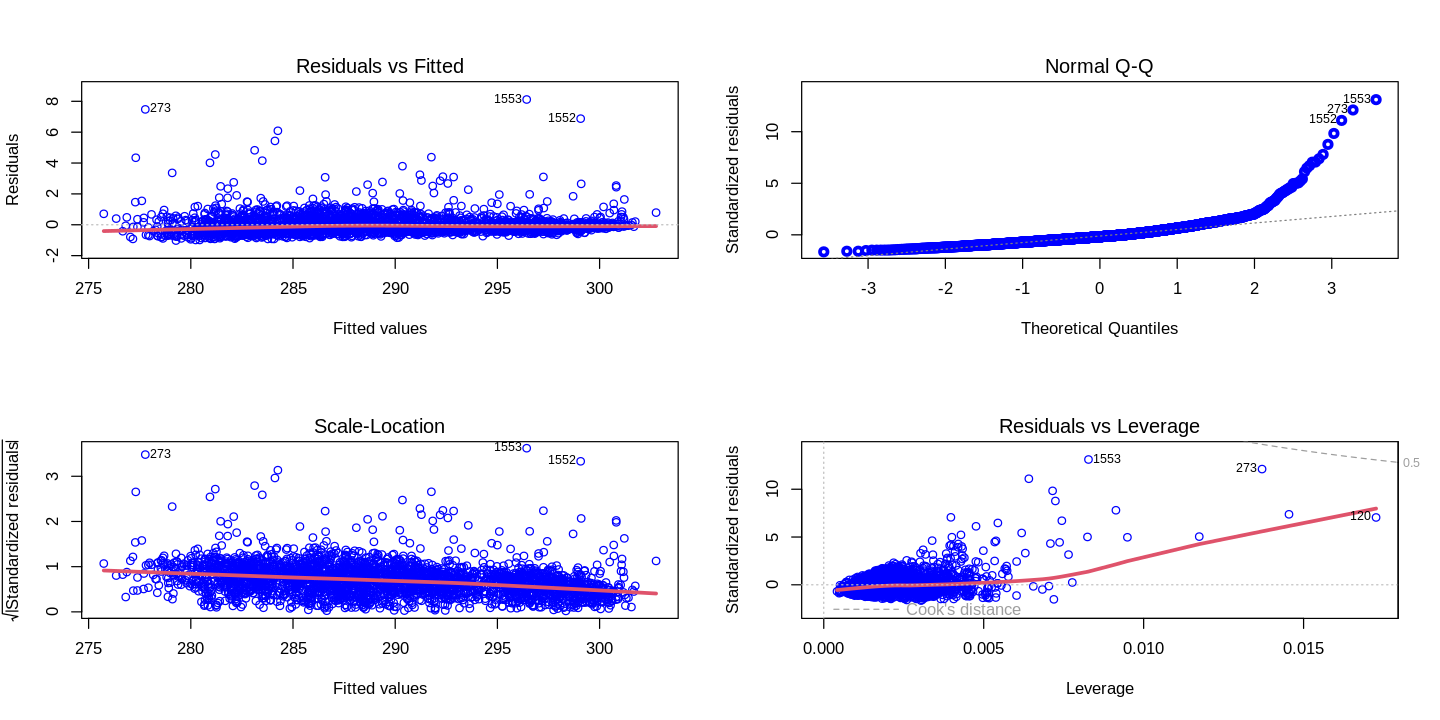

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 6)

par(mfrow=c(2,2))
plot(temp.multi.lm, col = "blue" , lwd=3)
par(mfrow=c(1,1))

Multivariate linear regression has another assumption that the predictor variables are __independent__. We can visualize the correlation matrix to confirm that.

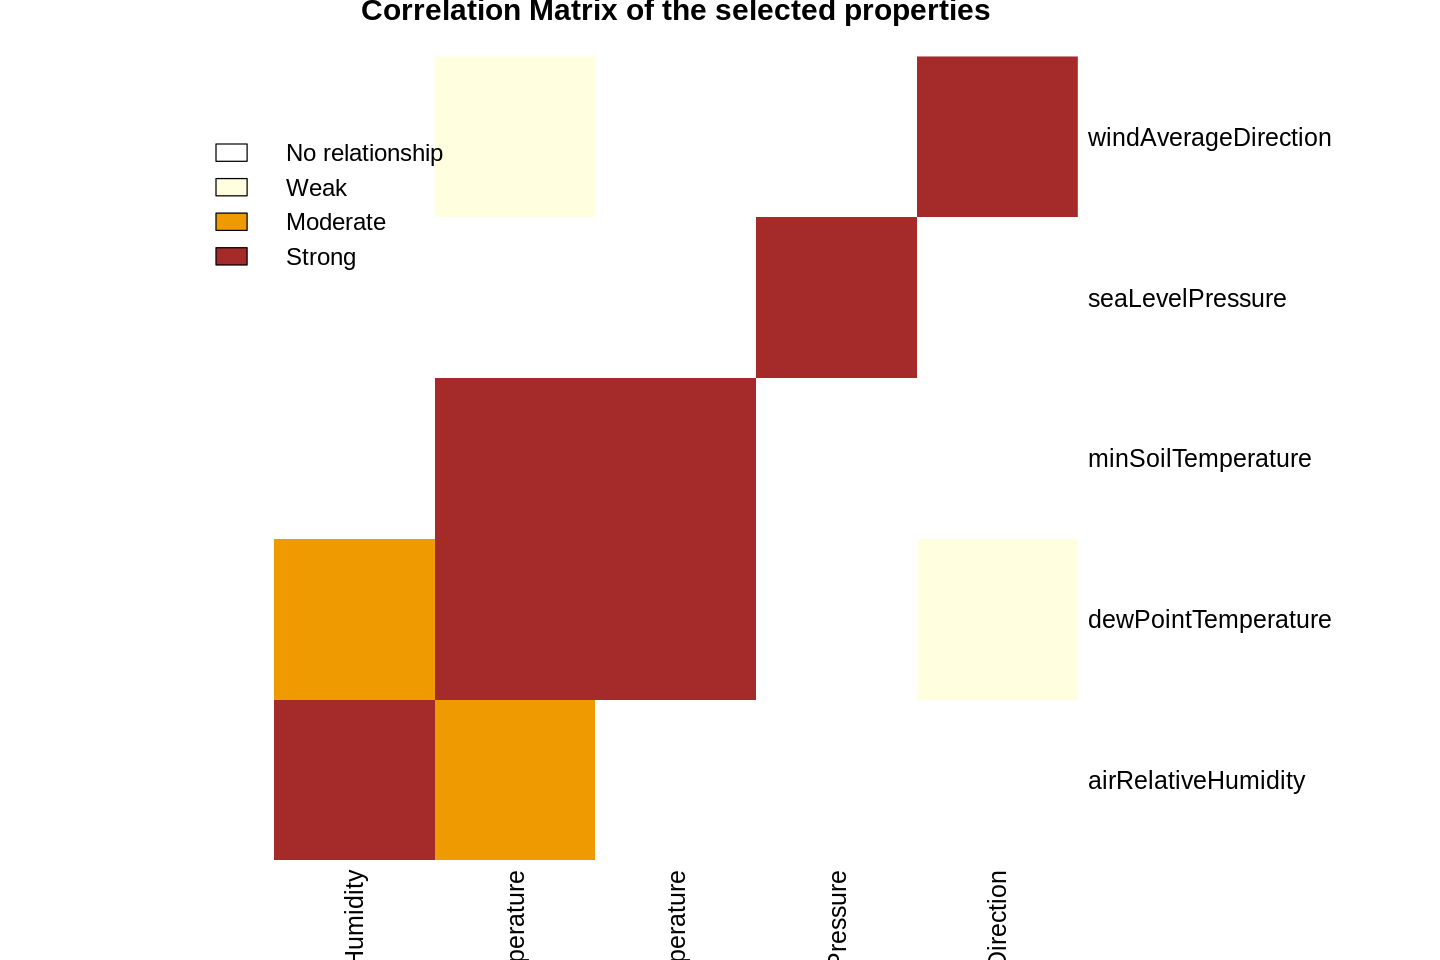

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

r.selected <- cor(weather_data_all.wide[, c('airRelativeHumidity', 'dewPointTemperature' , 'minSoilTemperature',
                                             'seaLevelPressure', 'windAverageDirection')], 
          method = "pearson", use = "complete.obs")

col <- c('white', 'lightyellow', 'orange2', 'brown')

heatmap(x = abs(r.selected), 
        symm=TRUE, 
        Rowv = NA, Colv = NA,  
        margines=c(12,12),
        cexCol=1.5,
        cexRow = 1.5,
        col=col,
        main="Correlation Matrix of the selected properties")

legend(x="topleft", 
       legend=c("No relationship", "Weak", "Moderate", "Strong"),
       fill=col,
       bty="n",
       cex=1.2,
       )

CONCLUSION:

- [x] Linearity of the data
- [x] Normality of residuals
- [x] Homoscedasticity
- [ ] Independence

By including weather properties selected by LASSO into regression to model airTemperature relations with other weather properties we've increased the coefficient of determination (R2) value to 0.99 which means that the 5 selected properties can explain 99% of the variation in the air temperature. 

The p-values for pre-selected variables are very low. 

The assumption of independence of the variables is not met. We can try to exclude either `dewPointTemperature` or `minSoilTemperature` and see how much variation we still can explain.

So we can tell that the major factors that affect the temperature are humidity, dew point, and air pressure. 

### Principal Component Analisys (PCA)

Let's identifiy the weather properties that mostly influence the _airTemperature_. 

TODO:

In [ ]:
#delete non-numeric columns and contant column
weather_data_all.wide.pca <- subset(weather_data_all.wide, select = -c( time , totalCoverHeight) )
#summary(weather_data_all.wide.pca)

In [ ]:
pca <- prcomp(weather_data_all.wide.pca[1:100, ], 
              center=TRUE,  scale.=TRUE,
              rank. = 6, na.rm = FALSE)

In [ ]:
options(width=100)
summary(pca)
pca

Importance of first k=6 (out of 13) components:
                          PC1    PC2    PC3     PC4     PC5     PC6
Standard deviation     2.1068 1.5274 1.3321 1.08654 0.95086 0.83764
Proportion of Variance 0.3414 0.1794 0.1365 0.09081 0.06955 0.05397
Cumulative Proportion  0.3414 0.5209 0.6574 0.74820 0.81774 0.87172

Standard deviations (1, .., p=13):
 [1] 2.106802452 1.527359193 1.332111939 1.086541202 0.950862443 0.837639521 0.799789141 0.720575855
 [9] 0.557183794 0.409386248 0.162320190 0.066209471 0.003052182

Rotation (n x k) = (13 x 6):
                             PC1          PC2         PC3         PC4          PC5         PC6
airRelativeHumidity  -0.38397159 -0.005107738  0.33037332 -0.08476546  0.116518830 -0.05970814
airTemperature       -0.29029109 -0.072895274 -0.39375709  0.32506849 -0.044023919 -0.11121363
dewPointTemperature  -0.45122423 -0.037381049  0.04962898  0.11297127  0.080085345 -0.10900708
differentialPressure  0.14969197 -0.375063055  0.03473731 -0.27726514  0.227377261 -0.61082161
gustSpeed             0.21464256 -0.439048716  0.25760157  0.40886690  0.004379403  0.15563047
horizontalVisibility  0.17715246 -0.206996055 -0.46198068 -0.18012332 -0.189035149  0.48167743
lowCloudCover        -0.06964785  0.408308369  0.22521631  0.20081802  0.316368993  0.38258041
minSoilTe

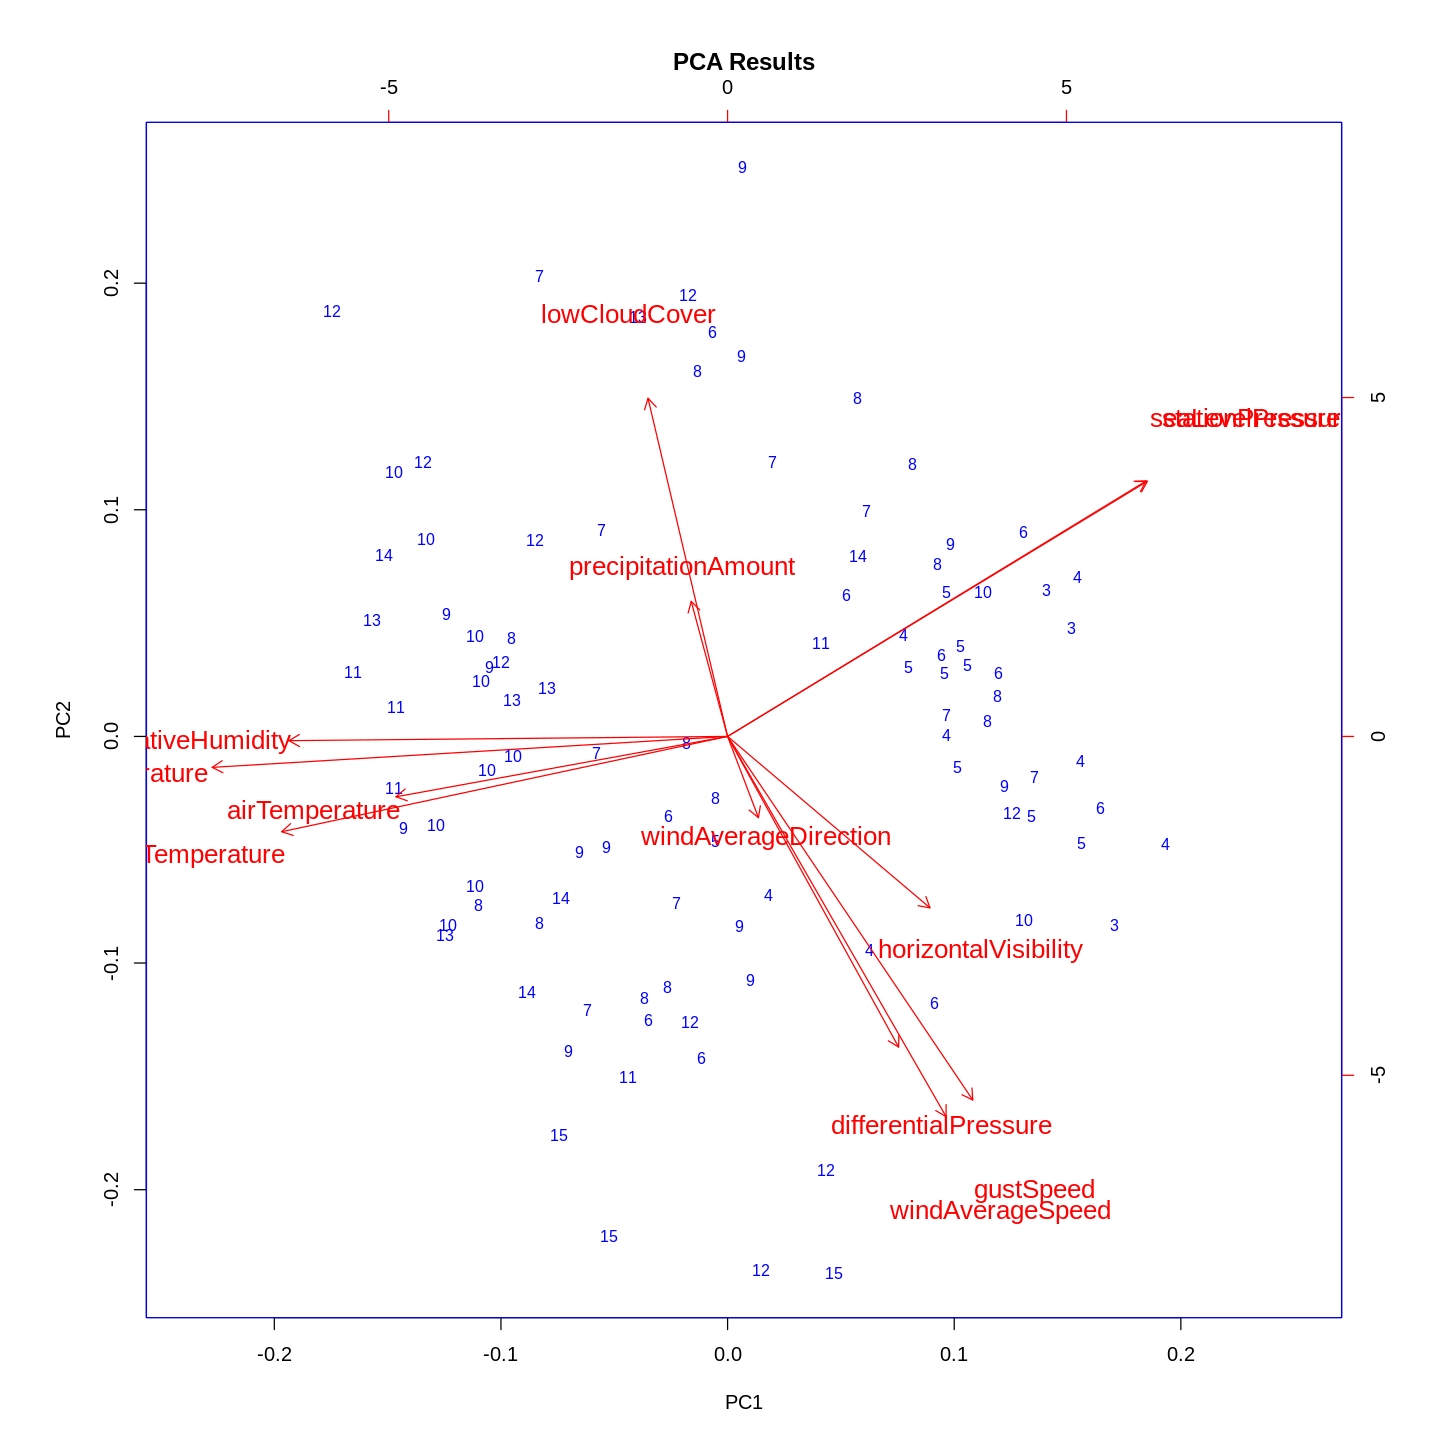

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 12)
options(repr.plot.align = 'left')

biplot(pca,  
       col=c('blue', 'red'),
       cex=c(0.8, 1.3),
       expand=1.2,
       #xlim= c(-0.1, 0.1), 
       #ylim= c(-0.1, 0.1), 
       xlabs=round(weather_data_all.wide$airTemperature[1:100]- 273.15), 
       main='PCA Results' )

CONCLUSION:


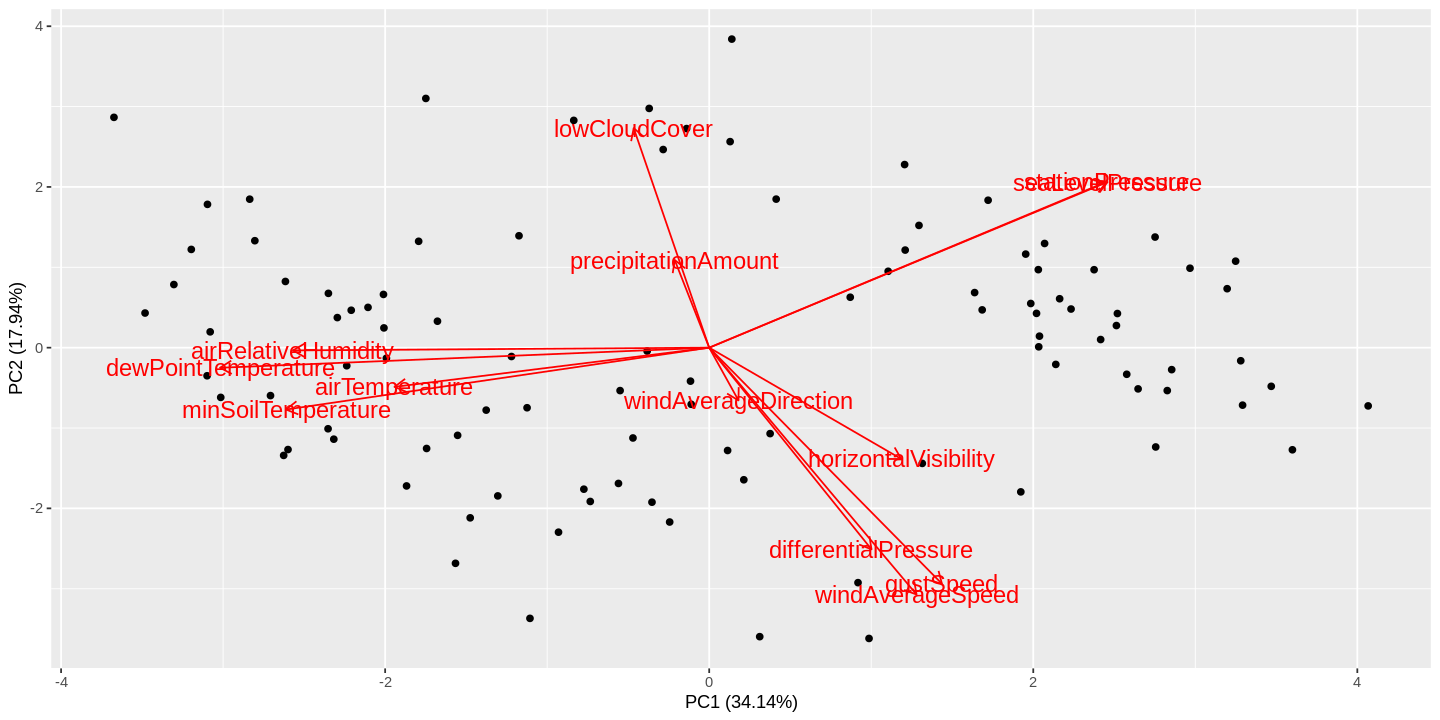

In [ ]:
if (!require(ggfortify)) {
  install.packages("ggfortify")
}
library(ggfortify)

options(repr.plot.width = 12)
options(repr.plot.height = 6)
options(repr.plot.align = 'left')

autoplot(pca, 
         loadings = TRUE, 
         loadings.label = TRUE,
         loadings.label.size = 5, 
         scale=0,
         label=FALSE)

In [ ]:
?autoplot.prcomp